# Plot canopy height model subsets for figures

Paul Montesano, PhD

In [1]:
import numpy as np
import os
import glob
import math

import rioxarray

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

import sys
sys.path.insert(0, '/home/pmontesa/code/pygeotools')
from pygeotools.lib import filtlib, iolib, malib, warplib
sys.path.insert(0, '/home/pmontesa/code/imview')
from imview.lib import pltlib
#import scipy.ndimage

In [2]:
import rasterio
from rasterio.plot import show_hist, show
from rasterio.windows import Window

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

#### Functions used in this notebook

In [25]:
from plotlib import *

In [3]:
def hillshade(array,azimuth,angle_altitude):
    #https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2
def do_scalebar(ax):
    return ax.add_artist(ScaleBar(
        dx=1,
        units="m",
        dimension="si-length",
         length_fraction=0.15,
        scale_formatter=lambda value, unit: f' {value} m ',
        location='lower left'
        ))
def do_colorbar(ax, fig, image_hidden, label, SIZE='1.5%' ):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=SIZE, pad=0.15) #pad=-0.1)
    cb = fig.colorbar(image_hidden, cax=cax, orientation='vertical', extend='max')
    cb.set_label(label)

In [4]:
def rescale_pct_clip(array, pct=[1,80]):
    '''Re-scales data values of an array from 0-1 with percentiles'''
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

def rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [4,3,2], pct=[5,95], nodata=-9999.0):
    
    # add a reduced res: https://gis.stackexchange.com/questions/434441/specifying-target-resolution-when-resampling-with-rasterio
    
    with rasterio.open(fn, "r+") as src1:
        
        src1.nodata = nodata
        arr_list = []
        for band in bandlist:
            arr = src1.read(band)
            arr_list.append(arr)
            
        with rasterio.open(rescaled_multiband_fn, 'w+',
                driver='GTiff',
                dtype= rasterio.float32,
                count=3,
                crs = src1.crs,
                width=src1.width,
                height=src1.height,
                transform=src1.transform,
                nodata=src1.nodata

            ) as dst:

            for i, band in enumerate(bandlist): 
                V = rescale_pct_clip(src1.read(band), pct=pct)
                dst.write(V,i+1)
            

In [5]:
from matplotlib.colors import LinearSegmentedColormap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

### Get dirs of $SR_{VHR}$, $CHM_{VHR}$, & $CLOUDMASK_{VHR}$

In [6]:
DIR_SR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/002m'
DIR_CHM = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/002m'
DIR_CLOUD = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/cloudmask/002m'

### Select strips
Use maps of footprints in `footprint_vhr_input.ipynb`

In [7]:
STRIPNAME_LIST = [
    'WV02_20200812_M1BS_10300100ABA8D400',
    'WV02_20200722_M1BS_10300100AB1FD100',
    'WV02_20160816_M1BS_103001005BA0F300',
    'WV02_20130712_M1BS_10300100241E8E00',
    'WV02_20190825_M1BS_1030010098B51F00',
    'WV02_20190820_M1BS_10300100968FB300',
    'WV02_20190820_M1BS_10300100954DE000',
    'WV02_20190824_M1BS_103001009A81F500',
    'WV02_20190710_M1BS_103001009409BC00'
             ]
# The windows of each image strip you want to plot in detail below
# These windows use an origin (0,0) that is in the upper left, and move positively right (x) and down (y)
# (ULX, ULY, LRX, LRY)
WIN_LIST = [
    (4000, 4000, 7000, 2500),
    (4500, 4500, 3500, 1250),
    (4500, 4500, 450, 125),
    (2500, 1000, 1500, 500),
    (4000, 20000, 7000, 2500),
    (4500, 4500, 4000, 1500),
    (800, 700, 4000, 1500),
    (4000, 20000, 4000, 1500),
    (4000, 20000, 4000, 1500)
]

In [8]:
STRIPNAME_WINDOW_DICT = dict(zip(STRIPNAME_LIST, WIN_LIST))

In [9]:
idx=-1
STRIPNAME = STRIPNAME_LIST[idx]
STRIPNAME

'WV02_20190710_M1BS_103001009409BC00'

In [10]:
glob.glob(DIR_CHM + '/**/**/' + STRIPNAME_LIST[idx] + '*.tif')

['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/002m/train_strips/WV02_20190710_M1BS_103001009409BC00-sr-02m/WV02_20190710_M1BS_103001009409BC00-sr-02m.cnn-chm-v1.tif']

In [11]:
fn_list_sr = glob.glob(DIR_SR + '/' + STRIPNAME_LIST[idx] + '*')
fn_list_chm = glob.glob(DIR_CHM + '/**/**/' + STRIPNAME_LIST[idx] + '*.tif')
fn_list_cloud = glob.glob(DIR_CLOUD + '/' + STRIPNAME_LIST[idx] + '*')
print(fn_list_chm)
fn_chm = fn_list_chm[0]

['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/002m/train_strips/WV02_20190710_M1BS_103001009409BC00-sr-02m/WV02_20190710_M1BS_103001009409BC00-sr-02m.cnn-chm-v1.tif']


## Rescale multi-band (CIR) image for viewing

In [12]:
fn = fn_list_sr[0]
outdir = os.path.dirname(fn)
STRIP_NAME = os.path.basename(fn)
outdir = '/explore/nobackup/people/pmontesa/tmp'
rescaled_multiband_fn = os.path.join(outdir, STRIP_NAME.replace('.tif', '_rescaled_multiband_temp.tif'))
rescale_multiband_for_plot(fn, rescaled_multiband_fn, pct=[23,99], nodata=-9999.0) 

## Plot full strip

In [13]:
sr_ds = rasterio.open(rescaled_multiband_fn)
cloud_da = rioxarray.open_rasterio(fn_list_cloud[0], masked=True).squeeze()
chm_da = rioxarray.open_rasterio(fn_list_chm[0], masked=True).squeeze()

(array([24350886., 45196525., 60065837., 54893293., 68585189., 77540724.,
        42995590., 12057689.,  4308973.,   417563.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

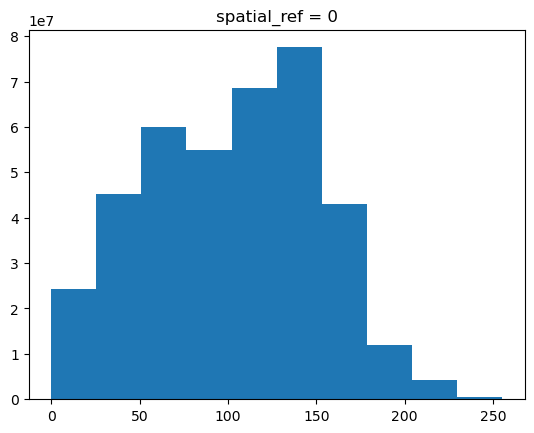

In [14]:
f = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/RGB_COG/kougarok_02_20240811_100m_transparent_mosaic_group1.tif'
rioxarray.open_rasterio(f, masked=True).squeeze().plot()

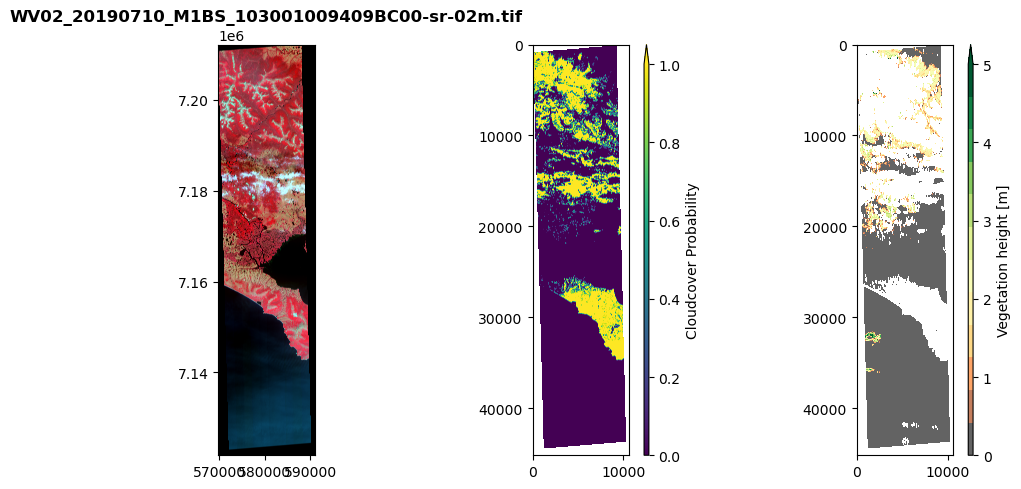

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10,5)) #sharex=True, sharey=True

m_sr = show(sr_ds.read(),transform=sr_ds.transform, ax=ax0, title=STRIP_NAME)
m_cloud = ax1.imshow(cloud_da)
m_chm = ax2.imshow(chm_da, cmap=forest_ht_cmap, clim=(0,5))

do_colorbar(ax1, fig, m_cloud, 'Cloudcover Probability', SIZE='5%' )
do_colorbar(ax2, fig, m_chm, 'Vegetation height [m]', SIZE='5%' )

plt.tight_layout()

## Get corresponding DEM

In [20]:
# Copernicus GLO30
dem_fn = '/explore/nobackup/projects/ilab/data/copernicus_dem/Copernicus_DSM_COG_10.vrt'
dem_warp_fn = f"{outdir}/{os.path.splitext(os.path.basename(dem_fn))[0]}_warp.tif"
print("Warping rasters to same res/extent/proj")
#ds_list = warplib.memwarp_multi_fn([rescaled_multiband_fn, dem_fn], extent=rescaled_multiband_fn, res=rescaled_multiband_fn, t_srs=rescaled_multiband_fn, r='cubic')
warplib.diskwarp_multi_fn([rescaled_multiband_fn, dem_fn], extent=rescaled_multiband_fn, res=rescaled_multiband_fn, t_srs=rescaled_multiband_fn, r='cubic', outdir=outdir)

Warping rasters to same res/extent/proj

Warping all inputs to the following:
Resolution: 2.0
Extent: [569737.0, 7121795.0, 590963.0, 7212105.0]
Projection: '+proj=utm +zone=3 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 2: /explore/nobackup/people/pmontesa/tmp/WV02_20190710_M1BS_103001009409BC00-sr-02m_rescaled_multiband_temp.tif
2 of 2: /explore/nobackup/projects/ilab/data/copernicus_dem/Copernicus_DSM_COG_10.vrt
nl: 45155 ns: 10613 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...

[<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x147f2feadc00> >,
 <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x147f2ed81c00> >]

## Plot a window

In [21]:
STRIPNAME_WINDOW_DICT

{'WV02_20200812_M1BS_10300100ABA8D400': (4000, 4000, 7000, 2500),
 'WV02_20200722_M1BS_10300100AB1FD100': (4500, 4500, 3500, 1250),
 'WV02_20160816_M1BS_103001005BA0F300': (4500, 4500, 450, 125),
 'WV02_20130712_M1BS_10300100241E8E00': (2500, 1000, 1500, 500),
 'WV02_20190825_M1BS_1030010098B51F00': (4000, 20000, 7000, 2500),
 'WV02_20190820_M1BS_10300100968FB300': (4500, 4500, 4000, 1500),
 'WV02_20190820_M1BS_10300100954DE000': (800, 700, 4000, 1500),
 'WV02_20190824_M1BS_103001009A81F500': (4000, 20000, 4000, 1500),
 'WV02_20190710_M1BS_103001009409BC00': (4000, 20000, 4000, 1500)}

In [22]:
STRIPNAME_WINDOW_DICT[STRIPNAME]

(4000, 20000, 4000, 1500)

In [23]:
# PNAME = 'WV02_20190820_M1BS_10300100968FB300'
# win = PNAME_WINDOW_DICT[PNAME]
# rescaled_multiband_fn = glob.glob(outdir + '/' + PNAME + '*')[0]

(1500, 4000)


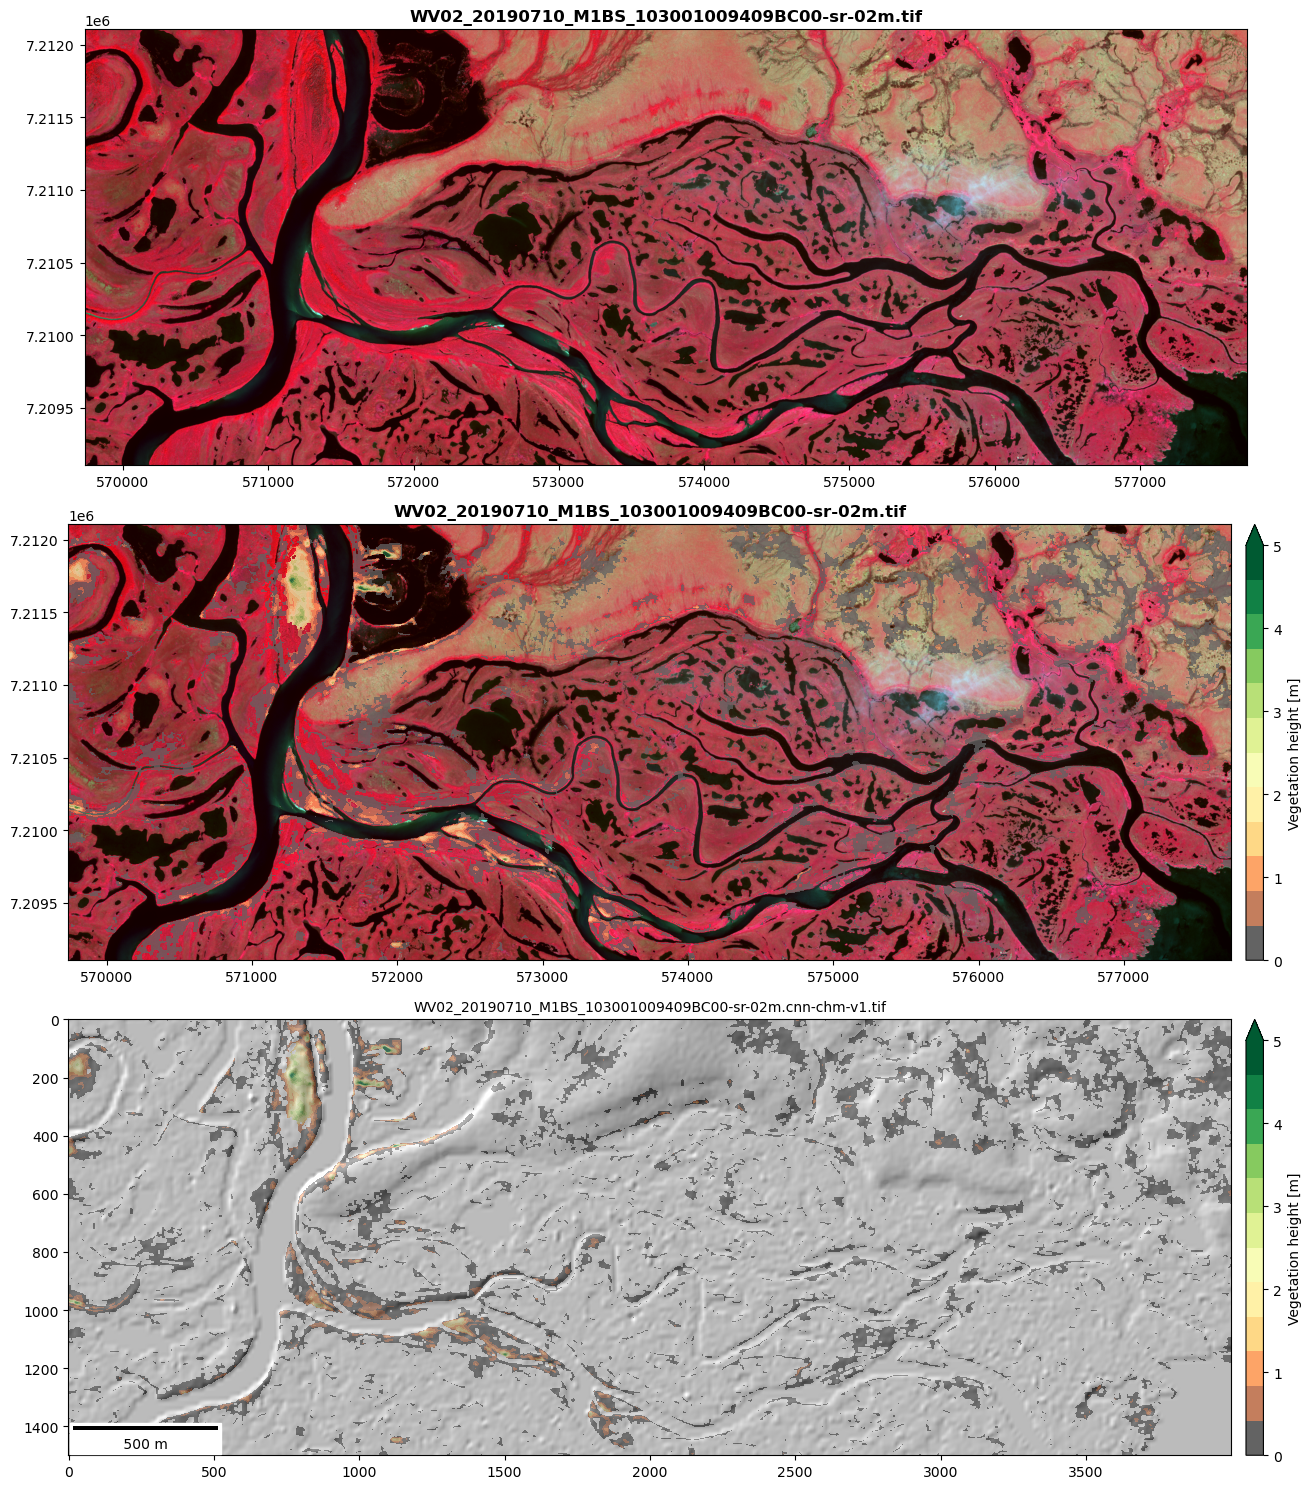

In [24]:
fig,(ax0, ax1, ax2)=plt.subplots(3,1, figsize=(20,15))#, sharex=True)


VMIN, VMAX = (0, 5)
window = Window(*STRIPNAME_WINDOW_DICT[STRIPNAME])

with rasterio.open(rescaled_multiband_fn) as src:
    # Plots a 3-band color image nicely
    show(src.read(window=window),transform=src.transform, ax=ax0, title=STRIP_NAME)
    show(src.read(window=window),transform=src.transform, ax=ax1, title=STRIP_NAME)

with rasterio.open(fn_chm) as chm_src:
    chm_arr = chm_src.read(1, window=window)
    chm_arr = np.ma.masked_where(chm_arr < 0.01, chm_arr)
    print(chm_arr.shape)
    image_hidden = ax2.imshow(chm_arr,  alpha=1, cmap=forest_ht_cmap, clim=(VMIN, VMAX), vmin=VMIN, vmax=VMAX)
    im1 = show(chm_arr, transform=src.transform, ax=ax1, cmap=forest_ht_cmap, title=STRIP_NAME, vmin=VMIN, vmax=VMAX, alpha=0.75)
    im2 = show(chm_arr, transform=src.transform, ax=ax2, cmap=forest_ht_cmap, title=os.path.basename(fn_chm), vmin=VMIN, vmax=VMAX)
    # Do hillshade for window
    with rasterio.open(dem_warp_fn) as dem_src:
        dem_ma =  dem_src.read(1, window=window)
        hs_ma = hillshade(dem_ma,315,1)
    im2 = ax2.imshow(hs_ma, cmap='gray', clim=malib.calcperc(hs_ma), alpha=0.5) # if hs is on, then sharex=False
    
    ax2.set_title(os.path.basename(fn_chm), fontsize=10)
    for ax in (ax1, ax2):
        do_colorbar(ax, fig, image_hidden, 'Vegetation height [m]')
    do_scalebar(ax2)

plt.tight_layout()